## Introduction
In machine learning workflows, the Pipeline class from Scikit-Learn is invaluable for streamlining data preprocessing and model training into a single, coherent sequence. A pipeline is essentially a sequence of data transformers that culminates with an optional final predictor. This structure enables seamless integration of preprocessing and predictive modeling, ensuring that the same data transformations applied during training are consistently applied to new data during prediction.

Each intermediate step in a pipeline must be a transformer, meaning it should implement both fit and transform methods. The final step, which is typically a predictive model, or estimator, only requires a fit method. The entire pipeline can be trained simultaneously using a method like GridSearchCV, resulting in self-contained predictor that can be used to make predictions on unseen data.

Importantly, the pipeline allows you to set the parameters of each of these steps using their names and parameter names connected by a double underscore `__`. For example, if a pipeline step is named `imputer` and you want to change its strategy, you can pass a parameter like `imputer__strategy='median'`. Additionally, steps can be entirely swapped out by assigning a different estimator or even bypassed by setting them to `'passthrough'` or `None`.

A major advantage of using a pipeline is that it enables comprehensive cross-validation and hyperparameter tuning for all steps simultaneously. By integrating the pipeline within GridSearchCV, you can fine-tune not only the model but also the preprocessing steps, leading to optimized overall performance. Pipelines are essential for scenarios where preprocessing involves estimators performing operations like scaling, encoding categorical variables, imputing missing values, and dimensionality reduction. Pipelines ensure these steps are reproducibly applied to both training and test data.


In this lab:
- Generate synthetic data for running targeted experiments using scikit-learn
- Train and evaluate a KNN classification model using a pipeline
- Tune model hyperparameters using a pipeline within a cross-validation grid search
- Build a more complex random forest classification pipeline using real-world data
- Extract the feature importances from the trained pipeline

**Load Libraries**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

**Load Data**

In [9]:
data = load_iris()
X, y = data.data, data.target
labels = data.target_names

#### Instantiate a pipeline consisting of StandardScaler, PCA, and KNeighborsClassifier

In [10]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),                   # Standardize features
    ('pca', PCA(n_components=2)),                   # Dimensionality reduction
    ('knn', KNeighborsClassifier(n_neighbors=5))    # KNeighbor Classification 
])

**Data Split**

* Stratify:</br>
Stratify manages class imbalance. If there are frequent (more dominating) classes, `stratify` make sures train and test set get the same ratio of classes.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Fit the Data**

In [17]:
pipeline.fit(X_train, y_train)

# Measure the pipeline accuracy on test data
score = pipeline.score(X_test, y_test)
print(f'Pipeline Score: {100*score:.3f}%')

Pipeline Score: 90.000%


**Get the model Prediction**

In [18]:
y_pred = pipeline.predict(X_test)

**Generate COnfusion Matrix and plot the data**

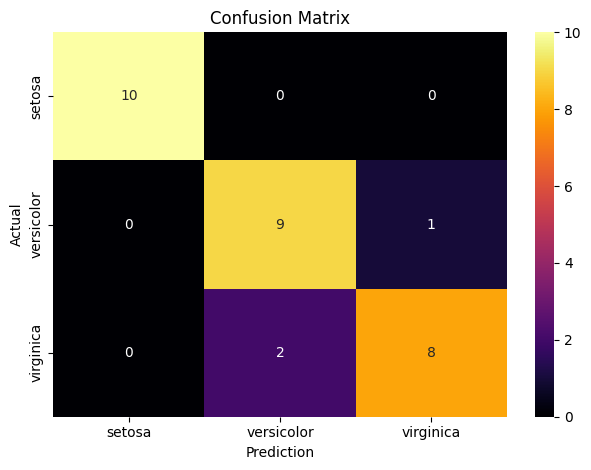

In [32]:
confusion_mat = confusion_matrix(y_test, y_pred)

# Lets plot the data
plt.figure()
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='inferno', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

**Observations**</br>
The model incorectly classified two viginica irises as versicolor, and one versicolor as virginica. Not bad, only three classification errors out of 30 irises on our first attempt!

## Tune hyperparameters using a pipeline within cross-validation grid search
We created a model but haven't yet attempted to optimize its performance.  Let's see if we can do better.
Recall that it would be a mistake to keep running the model over and over again with different hyperparamters to find the best one.  
You would effectively be overfiiting the model to your test data set.  
The correct way to handle this tuning is to use cross validation. 

Let's see how it works, using the same data set.
### Instantiate the pipeline
We'll preprocess the data by scaling it and transforming it onto a to-be-determined number of principle components, follow that up with a KNN model classifier, and combine these estimators into a pipeline. We'll then optimize the pipeline using crossvalidation over a hyperparameter grid search. This will allow us find the best model for the set of trial hyperparamters.


In [33]:
pipeline_ = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())
])

### Define a model parameter grid to search over

In [51]:
# Hyperparameter search grid for numbers of PCA components and KNN neighbors
param_grid = {
    'pca__n_components': [2, 3],
    'knn__n_neighbors': [3, 5, 7]
}

### Choose a cross validation method
To ensure the target is stratified, we can use scikit-learn's `StratifiedKFold` cross-validation class.


In [52]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Determine the best parameters
Pass your `pipeline`, `param_grid`, and the `StratifiedKFold` cross validation method to `GridSearchCV`

In [53]:
best_params = GridSearchCV(
    param_grid=param_grid,
    estimator=pipeline_,
    cv=cv,
    verbose=2,
    scoring='accuracy'
)

### Fit the best `GridSearchCV` model to the training data


In [54]:
best_params.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ............knn__n_neighbors=3, pca__n_components=2; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=2; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=2; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=2; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=2; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=3; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=3; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=3; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=3; total time=   0.0s
[CV] END ............knn__n_neighbors=3, pca__n_components=3; total time=   0.0s
[CV] END ............knn__n_neighbors=5, pca__n_components=2; total time=   0.0s
[CV] END ............knn__n_neighbors=5, pca__n_c

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [3, 5, 7],
                         'pca__n_components': [2, 3]},
             scoring='accuracy', verbose=2)

### Evaluate the accuracy of the best model on the test set

In [56]:
score_ = best_params.score(X_test, y_test)
print(f'Model Score: {100*score_:.3f}%')

Model Score: 93.333%


**Display best parameters**

In [57]:
best_params.best_params_

{'knn__n_neighbors': 3, 'pca__n_components': 3}

**Lets plot the `confusion_matrix` for tuned parameters**

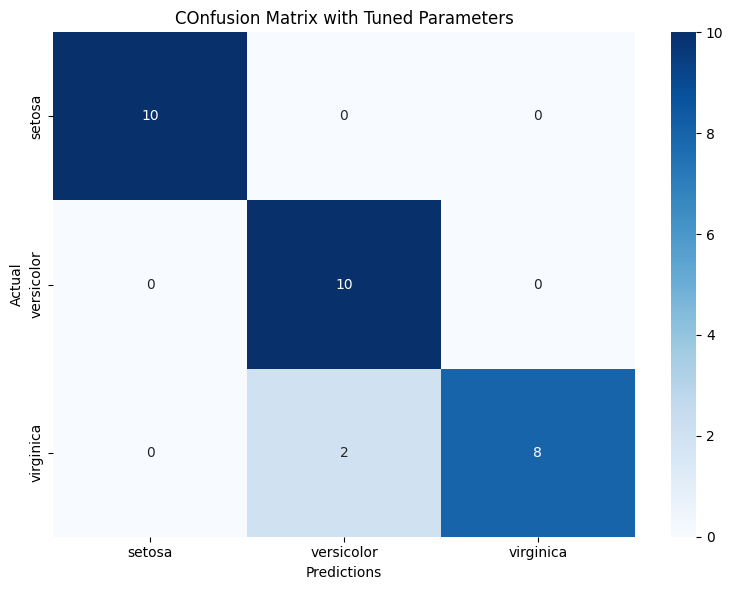

In [58]:
y_pred_ = best_params.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred_)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('COnfusion Matrix with Tuned Parameters')
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

**Observations**

Model did very well as only two wrong predictions.